# Dane

Będziemy pracować na danych dotyczących rodzajów fonacji (nastawienia głosu). Dane zawierają 13 MFCC oraz ich pierwszą i drugą pochodną wyznaczone dla sygnałów zawierających samogłoski emitowane przy użyciu dwóch typów fonacji:

- z nastawieniem miękkim - więzadła głosowe zbliżają się do siebie, a ich przyśrodkowe krawędzie swobodnie drgają
- z nastawieniem twardym - więzadła głosowe są silnie zwarte przed rozpoczęciem fonacji, tworzy się wysokie ciśnienie podgłośniowe.

Rodzaje te są oznaczone odpowiednio etykietami 0 i 1.

Źródło danych: https://osf.io/cwquj/. Więcej o rodzajach nastawienia głosu [w artykule autorów zbioru danych](https://research.gold.ac.uk/id/eprint/9621/1/phonation-r11.pdf) lub po polsku [w poradniku higieny głosu (str. 11).]( https://medycynapracyportal.pl/wp-content/uploads/wydawnictwa/poradnik_glos.pdf)

In [39]:
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, RocCurveDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import os

In [40]:
#wczytanie danych
X = np.load(os.path.join('Lab6-zad1','padded_features_bin.npy')) #macierz cech - jednej wiersz = jeden obiekt
y = np.load(os.path.join('Lab6-zad1','labels_bin.npy')) #etykiety

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42) 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Maszyna wektorów nośnych

Przeprowadzimy analizę przy użyciu klasyfikatora opartego o maszynę wektorów nośnych [(*support vector machine*, SVM)](https://scikit-learn.org/stable/modules/svm.html#support-vector-machines) (`from sklearn.svm import SVC`). 

### Przypomnienie:

> SVM umożliwia klasyfikację również wtedy, gdy dane nie są liniowo separowalne. Wykorzystywana jest do tego funkcja jądra (*kernel*), która służy do mapowania danych na przestrzeń o wymiarze o jeden większym, gdzie już są (lub przynajmniej powinny być) liniowo separowalne.

> SVM dąży nie tylko do rozdzielenia danych należących do różnych klas, ale też zrobienia tego z możliwie dużym marginesem zaufania. O tym, jak wysoka jest kara, która jest następstwem złej klasyfikacji obiektu, oraz jak duży jest margines, informuje parametr C (im mniejsze C, tym bardziej uogólniony model i większy margines).

Ponieważ chcemy wyznaczyć krzywą ROC i ROC AUC (zob. notatnik **Regresja_metryki_ciagle.ipynb**), zamiast metody `predict` użyjemy [`predict_proba`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.predict_proba) (od *probability*), która zwróci prawdopodobieństwo przynależności do klas (dla każdej klasy w osobnej kolumnie). Tworząc model, musimy więc pamiętać, aby ustawić `probability=True`, żeby zwrócił nam prawdopodobieństwa.


In [42]:
SVM = SVC(C=1, random_state=42, probability=True) #probability=True pozwala potem użyć metody predict_proba
SVM.fit(X_train_scaled, y_train)
SVM_train_preds = SVM.predict_proba(X_train_scaled)
SVM_test_preds = SVM.predict_proba(X_test_scaled)
print('test ROC AUC: ', roc_auc_score(y_test, SVM_test_preds[:,1])) 
#predict_proba zwraca macierz z prawdopodobieństwiem przynależności do każdej analizowanej klasy
#nas interesuje klasa 1, więc bierzemy kolumnę 1, w której są odpowiednie prawdopodobieństwa

test ROC AUC:  0.9862068965517241


# Próg klasyfikacji

Użycie metody `predict_proba` spowodowało, że nasz klasyfikator (podobnie jak modele regresyjne) zwrócił predykcje ciągłe (wartości prawdopodobieństwa), z których nie można wprost wyliczyć metryk sukcesu. Żeby to zrobić, trzeba je zamienić na liczby całkowite, oznaczające przynależność do klas. W tym celu trzeba przyjąć pewien próg - wartości poniżej niego będą oznaczały przyporządkowanie do klasy 0, a pozostałe do klasy 1.

Są różne metody wyznaczania takiego progu - my przyjmiemy wartość, która będzie wyznaczona jako największa średnia geometryczna TPR i (1-FPR) dla całego zbioru danych (czyli w zasadzie potraktujemy zbiór testowy jak ewaluacyjny - służący do poprawy modelu, ale nie jego ostatecznej weryfikacji). Narysujemy wykres z zaznaczonym progiem, żeby łatwiej było sobie wyobrazić, o który dokładnie punkt chodzi.

Best Threshold=0.515, G-Mean=0.986


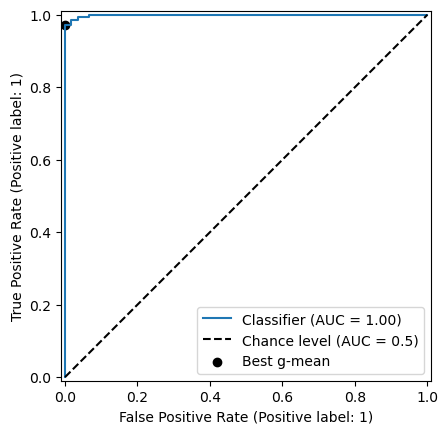

In [43]:
all_preds = np.append(SVM_train_preds[:,1], SVM_test_preds[:,1], axis=0)
all_labels = np.append(y_train, y_test)

fpr, tpr, thresholds = roc_curve(all_labels, all_preds, pos_label=1) # wyznaczamy krzywą ROC
gmeans = np.sqrt(tpr * (1-fpr)) # każdego punktu na krzywej ROC wyznaczamy średnią geometryczną
ix = np.argmax(gmeans) # indeks wartości maksymalnej

axis = plt.gca()
RocCurveDisplay.from_predictions(all_labels, all_preds, ax=axis, plot_chance_level=True) # rysujemy krzywą dla obu zbiorów
axis.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best g-mean')
plt.legend()
print('Best Threshold=%.3f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix])) #G-Mean - największa średnia geometryczna

Z wyznaczania progu będziemy jeszcze z tego korzystać, więc zapiszmy go do funkcji:

In [44]:
def get_threshold(y_train, y_test, train_preds, test_preds):
    y = np.append(y_train, y_test)
    preds = np.append(train_preds, test_preds)
    fpr, tpr, thresholds = roc_curve(y, preds)
    gmeans = np.sqrt(tpr * (1-fpr)) #średnie geometryczne wyznaczone dla każdego punktu na krzywej ROC
    ix = np.argmax(gmeans) # indeks wartości maksymalnej
    print('Best Threshold=%.3f' % thresholds[ix])
    return thresholds[ix], (fpr[ix], tpr[ix])

Wyznaczmy teraz próg klasyfikacji, korzystając ze średniej geometrycznej; generalnie krzywą ROC rysujemy tylko dla zbioru testowego, więc punkt progowy (wyznaczany na podstawie całego zbioru danych) niekoniecznie musi na niej leżeć.

Wyświetlimy też wartości prawdopodobieństwa zwrócone przez model.

In [45]:
threshold, (fpr_thres, tpr_thres) = get_threshold(y_train, y_test, SVM_train_preds[:,1], SVM_test_preds[:,1])

Best Threshold=0.515


Próg jest na potrzebny, aby otrzymane prawdopodobieństwa zamienić na klasy - wystarczająco wysoka wartość prawdopodobieństwa oznacza, że obiekt możemy zaklasyfikować jako „pozytywny”. Potem możemy wyznaczyć macierz pomyłek i metryki:

In [46]:
boolean_SVM_test_preds = SVM_test_preds[:,1] >= threshold

print('Threshold', threshold)
print(confusion_matrix(y_test, boolean_SVM_test_preds))
print('Accuracy', accuracy_score(y_test, boolean_SVM_test_preds))
print('Sensitivity/Recall', recall_score(y_test, boolean_SVM_test_preds))
print('Precision', precision_score(y_test, boolean_SVM_test_preds))

print('test ROC AUC: ', roc_auc_score(y_test, boolean_SVM_test_preds))

Threshold 0.5149885312996085
[[58  0]
 [ 4 31]]
Accuracy 0.956989247311828
Sensitivity/Recall 0.8857142857142857
Precision 1.0
test ROC AUC:  0.9428571428571428


Zobacz, jak wyniki będą zmieniać się w zależności od dobranego progu - wybierz kilka losowych wartości z przedziału [0,1] i wyznacz macierze pomyłek lub wybraną metrykę.

In [63]:
for thr in np.arange(0.1, 1.1, 0.1):
    boolean_SVM_test_preds = SVM_test_preds[:,1] >= thr
    print(confusion_matrix(y_test, boolean_SVM_test_preds))
    print('test ROC AUC: ', roc_auc_score(y_test, boolean_SVM_test_preds))
    print('\n')

[[50  8]
 [ 1 34]]
test ROC AUC:  0.9167487684729064


[[53  5]
 [ 2 33]]
test ROC AUC:  0.9283251231527093


[[54  4]
 [ 4 31]]
test ROC AUC:  0.9083743842364532


[[58  0]
 [ 4 31]]
test ROC AUC:  0.9428571428571428


[[58  0]
 [ 4 31]]
test ROC AUC:  0.9428571428571428


[[58  0]
 [ 7 28]]
test ROC AUC:  0.9


[[58  0]
 [ 7 28]]
test ROC AUC:  0.9


[[58  0]
 [ 9 26]]
test ROC AUC:  0.8714285714285714


[[58  0]
 [10 25]]
test ROC AUC:  0.8571428571428572


[[58  0]
 [35  0]]
test ROC AUC:  0.5




Porównaj wyniki uzyskane przez progowanie wartości prawdopodobieństwa z tymi, które uzyskuje się przez klasyfikację metodą `predict`. Czy są takie same? Z jakiej wartości progu korzysta ta metoda?

In [64]:
SVM_test_preds2 = SVM.predict(X_test_scaled)
print(confusion_matrix(y_test, SVM_test_preds2))
print(accuracy_score(y_test, SVM_test_preds2))
print(recall_score(y_test, SVM_test_preds2))

[[58  0]
 [ 7 28]]
0.9247311827956989
0.8


# Optymalizacja

Dotychczas wszystkie modele tworzyliśmy w taki sposób, że samodzielnie dobieraliśmy wartości hiperparametrów. Zazwyczaj było to robione w sposób losowy.

W praktyce wartości hiperparametrów warto dobierać na drodze optymalizacji. Przeprowadzimy taką optymalizację modelu SVM przy użyciu pakietu [**optuna**](https://optuna.org/).

In [49]:
# !pip install optuna
from optuna import create_study
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate, StratifiedKFold
import pickle

/opt/anaconda3/envs/pum/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Walidacja krzyżowa

Skorzystamy w tym celu z walidacji krzyżowej (*cross-validation*). Do tej pory wykonywaliśmy walidację prostą - dane były dzielone na zbiór uczący i testowy, a model ocenialiśmy tylko na podstawie metryk wyliczonych dla zbioru testowego.

### Przypomnienie

> Walidacja krzyżowa jest alternatywnym podejściem do oceny modelu. Dane wykorzystywane w procesie uczenia są dzielone na *k* podzbiorów (tzw. foldów) i uczenie przebiega w następujący sposób:

> 1. k-1 podzbiorów tworzy zbiór uczący, na którym uczony jest model, a ostatni pozbiór służy do walidacji (czyli przeprowadzenia predykcji i wyznaczenia metryk);
    
> 2. proces powtarzany jest k-krotnie, tak by każdy z podzbiorów był użyty do walidacji;
    
> 3. wyniki ze wszystkich k predykcji są uśredniane;
    
> 4. można wyliczyć też odchylenie standardowe wyników uzyskanych na wszystkich foldach - wtedy mamy informację, czy model zawsze daje zbliżone wyniki, czy też zdarzyło się, że na którymś foldzie dał dużo niższe niż na innych (nie jest to pożądane).

Korzystamy z funkcji [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold), która przy okazji zapewnia stratyfikację danych podczas dzielenia na podzbiory.

### Uwaga:

Często można spotkać się z tym, że do walidacji krzyżowej użyte są całe posiadane dane (nie wyodrębnia się zbioru testowego). Takie podejście nie jest polecane, ponieważ nie daje pełnego oglądu możliwości modelu. Najbardziej rekomendowane jest prowadzenie walidacji krzyżowej z wykorzystaniem zbioru uczącego (który w jej trakcie jest dzielony na podzbiory treningowy i walidacyjny), a następnie przeprowadzenie dodatkowej oceny modelu z użyciem zbioru testowego - tak będziemy robić na zajęciach.

## Funkcja kosztu (celu)

`scoring`

Przede wszystkim musimy zdefiniować, jaka metryka będzie służyła do oceny tego, który model (z jakimi hiperparametrami) jest lepszy - „zmapować” zmienne, którymi manipulujemy, do jednej wartości. W przypadku modeli regresyjnych używanych do klasyfikacji jest zazwyczaj to ROC AUC lub *log loss* (w przypadku regresorów dopasowywanych do danych ciągłych najczęściej jest to MSE - *mean squared error* lub MAE - *mean absolute error*). My wykorzystamy ROC AUC.

`objective`

Kolejną rzeczą, której potrzebujemy, jest funkcja, która nam to mapowanie wykona. Do niej podawany jest model, liczba prób wykonywana podczas całego procesu optymalizacji (losowań wartości hiperparametrów), optymalizowane hiperparametry, oraz dane uczące - zwraca wybraną przez nas metrykę.

In [50]:
scoring = {'roc_macro': make_scorer(roc_auc_score, average='macro')}

def objective(trial, model, get_space, X, y):
    model_space = get_space(trial)

    mdl = model(**model_space)
    scores = cross_validate(mdl, X, y,
                            scoring=scoring,
                            cv=StratifiedKFold(n_splits=5),
                            return_train_score=True)

    return np.mean(scores['test_roc_macro'])

Kolejną rzeczą, którą należy określić przed dokonaniem optymalizacji, są hiperparametry, które będą optymalizowane oraz zakresy wartości, które będą mogły przyjąć. Na razie będziemy wykorzystywać trzy rodzaje hiperparametrów:

1. przyjmujące tylko wartości całkowite, np. liczba iteracji, liczba sąsiadów w metodzie kNN - do zdefiniowania możliwych wartości należy użyć metody `suggest_int()`;
    
2. przyjmujące wartości kategorialne, np. rodzaj jądra (kernel) - do zdefiniowania możliwych wartości należy użyć metody `suggest_categorical()`;
    
3. przyjmujące wartości rzeczywiste, często z przedziału [0,1] - do zdefiniowania możliwych wartości należy użyć metody `suggest_float()`.
    

In [51]:
def get_space(trial): 
    space = {"C": trial.suggest_float("C", 0, 1.5),  # parametr regularyzacji
           'max_iter': trial.suggest_int('max_iter', 100, 100), # maksymalna liczba iteracji do zbiegnięcia modelu
           "kernel": trial.suggest_categorical("kernel", ["rbf", "linear", "poly"])} # funkcja jądra
    return space

Dodatkowo definiujemy model, którego chcemy użyć (w tym przypadku regresja logistyczna) oraz liczbę prób (triali), które będą wykonane w celu ustalenia najlepszych hiperparametrów. Na razie dajemy małą liczbę prób, żeby nie tracić zbyt dużo czasu - niestety optymalizacja jest bardzo czasochłonna. W przypadku bardziej skomplikowanych modeli, o dużej liczbie hiperparametrów, liczba triali musi być zdecydowanie większa niż 5, żeby sprawdzić różne możliwe kombinacje wartości - może wynosić nawet kilka(dziesiąt) tysięcy.

Gdy mamy już wszystko zdefiniowane, możemy w końcu przejść do optymalizacji. Określamy jeszcze, czy metryka stosowana przez nas ma być maksymalizowana czy minimalizowana - chcemy mieć jak największy ROC AUC, więc wybieramy `direction='maximize'` i rozpoczynamy optymalizację.

In [52]:
model = SVC # bez nawiasów! - przekazujemy klasę, nie tworzymy jej instancji
trials = 5 # liczba prób

study = create_study(direction='maximize')
study.optimize(lambda x: objective(x, model, get_space, X_train_scaled, y_train), n_trials=trials)

[I 2025-11-17 10:26:47,678] A new study created in memory with name: no-name-f195f3ba-42c1-4b38-b4a5-dba59b077d44
/opt/anaconda3/envs/pum/lib/python3.10/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/envs/pum/lib/python3.10/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/envs/pum/lib/python3.10/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/envs/pum/lib/python3.10/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMa

Gdy model jest już zoptymalizowany, możemy wyświetlić wartości najlepszych hiperparametrów:

In [53]:
print('params: ', study.best_params)

params:  {'C': 1.2593675740383206, 'max_iter': 100, 'kernel': 'linear'}


Następnie uczymy model o dobranych hiperparametrach i prowadzimy predykcję, żeby zobaczyć, czy faktycznie uzyskujemy dobre wyniki:

In [54]:
SVM_opt = model(**study.best_params) # rozpakowujemy słownik z najlepszymi parametrami

SVM_opt.fit(X_train_scaled, y_train)
preds = SVM_opt.predict(X_test_scaled)

pickle.dump(SVM_opt, open('SVM_model', 'wb+'))
print('test ROC_AUC: ', roc_auc_score(y_test, preds))

test ROC_AUC:  0.9857142857142858


/opt/anaconda3/envs/pum/lib/python3.10/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Porównaj uzyskaną wartość ROC AUC z tą, którą uzyskaliśmy samodzielnie dobierając wartości hiperparametrów. Możesz spróbowac zwiększyć liczbę triali, jeżeli wyniki nie są satysfakcjonujące.

Uproszczonym wariantem doboru hiperparametrów jest tzw. [*grid search*](https://scikit-learn.org/stable/modules/grid_search.html#grid-search), czyli sprawdzanie różnych kombinacji z góry określonych wartości hiperparametrów.